In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numba import jit

# Q1

In [2]:
Xtr=np.loadtxt('./Xtrain.csv')
ytr=np.loadtxt('./Ytrain.csv')
Xtt=np.loadtxt('./Xtest.csv')

print("There are",len(Xtr),"training examples and",len(Xtt),"test examples.")

There are 3000 training examples and 3000 test examples.


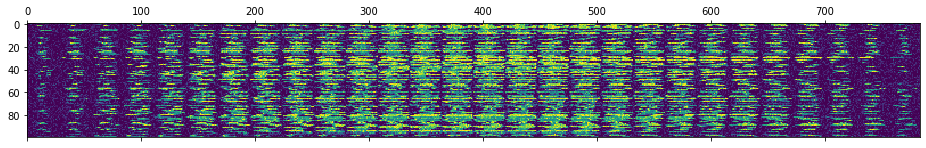

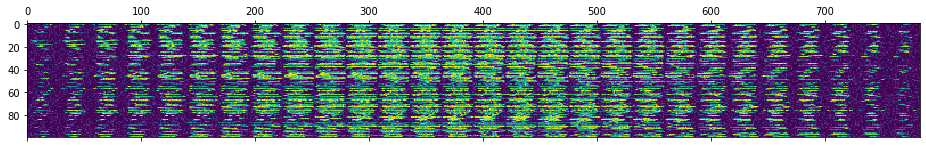

In [3]:
rand_Xtr = np.arange(Xtr.shape[0])
np.random.shuffle(rand_Xtr)
plt.matshow(Xtr[rand_Xtr[0:100]])
rand_Xtt = np.arange(Xtt.shape[0])
np.random.shuffle(rand_Xtt)
plt.matshow(Xtt[rand_Xtt[0:100]])

In [4]:
num_pos_tr = list(ytr).count(1)
num_neg_tr = list(ytr).count(-1)
print("There are",num_pos_tr,"positive examples and",num_neg_tr,"negative examples in the training dataset.")

There are 1824 positive examples and 1176 negative examples in the training dataset.


Accuracy= 0.5058333333333334


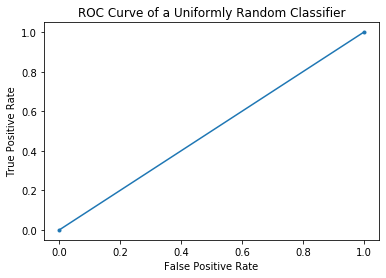

AUC_ROC= 0.5


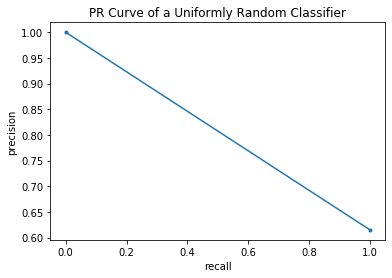

AUC_PR= 0.8075


In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc,precision_recall_curve

X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.4, random_state=1)
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict_proba(X_test)

print("Accuracy=",accuracy_score(y_test, dummy_clf.predict(X_test)))

fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1],pos_label=1)
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve of a Uniformly Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print("AUC_ROC=",auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])
plt.plot(recall, precision, marker='.')
plt.title("PR Curve of a Uniformly Random Classifier")
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()
print("AUC_PR=",auc(recall, precision))

iii. I should use AUC-PR, because the data is imbalanced, i.e. the number of positive examples and the number of negative examples are not equal. 

iv. The expected accuracy of a random classifier with balanced dataset should be $0.5$. However, in this example, the dataset is about 2:1 imbalanced.
$$\begin{aligned}
ACC&=\frac{TP+TN}{TP+TN+FP+FN}\\
&=P(condition=1)\times P(prediction=1) + P(condition=-1)\times P(prediction=-1)\\
&=\frac{1824}{3000}\times\frac{1824}{3000}+\frac{1176}{3000}\times\frac{1176}{3000}\\
&=52.33\%
\end{aligned}$$

v. The AUC-ROC is $0.5$ and the curve is a line. It is because in a random classifier,
$TPR=\frac{TP}{TP+FN}=(\text{total_examples}\times \text{threshold})\times \text{proportion_pos}/\text{num_pos}=\text{threshold}=FPR$


# Q2

In [19]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold,cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer

skf = StratifiedKFold(n_splits=5,shuffle = True)

In [7]:

ACC = []
ROC = []
PR = []
for i,(tr_idx, v_idx) in enumerate(skf.split(Xtr, ytr)):
    X_train, X_v = Xtr[tr_idx], Xtr[v_idx]
    y_train, y_v = ytr[tr_idx], ytr[v_idx]
    clf =  KNN(n_neighbors=1)
    clf.fit(X_train,y_train)
    acc = accuracy_score(y_v, clf.predict(X_v))
    ACC.append(acc)
    y_pred = clf.predict_proba(X_v)
    fpr, tpr, _ = roc_curve(y_v, y_pred[:, 1],pos_label=1)
    auc_roc = auc(fpr, tpr)
    ROC.append(auc_roc)
    precision, recall, _ = precision_recall_curve(y_v, y_pred[:, 1])
    auc_pr = auc(recall, precision)
    PR.append(auc_pr)
    print('Fold %d : Accuracy = %0.4f, AUC_ROC = %0.4f, AUC_PR = %0.4f' % (i+1,acc,auc_roc,auc_pr))


Fold 1 : Accuracy = 0.8003, AUC_ROC = 0.7982, AUC_PR = 0.8899
Fold 2 : Accuracy = 0.8017, AUC_ROC = 0.7945, AUC_PR = 0.8880
Fold 3 : Accuracy = 0.8450, AUC_ROC = 0.8430, AUC_PR = 0.9153
Fold 4 : Accuracy = 0.8133, AUC_ROC = 0.8132, AUC_PR = 0.8990
Fold 5 : Accuracy = 0.8197, AUC_ROC = 0.8170, AUC_PR = 0.9005


In [8]:
print('Fold-Wise Accuracy: the mean = %f, standard deviation = %f' % (np.mean(ACC),np.std(ACC)))
print('Fold-Wise  AUC_ROC: the mean = %f, standard deviation = %f' % (np.mean(ROC),np.std(ROC)))
print('Fold-Wise   AUC_PR: the mean = %f, standard deviation = %f' % (np.mean(PR),np.std(PR)))

Fold-Wise Accuracy: the mean = 0.816006, standard deviation = 0.016203
Fold-Wise  AUC_ROC: the mean = 0.813194, standard deviation = 0.017197
Fold-Wise   AUC_PR: the mean = 0.898536, standard deviation = 0.009713


In [9]:

ACC1 = []
ROC1 = []
PR1 = []
for i,(tr_idx, v_idx) in enumerate(skf.split(Xtr, ytr)):
    X_train, X_v = Xtr[tr_idx], Xtr[v_idx]
    y_train, y_v = ytr[tr_idx], ytr[v_idx]
    
    pipe = make_pipeline(StandardScaler(), KNN(n_neighbors=1))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_v)
       
    acc = accuracy_score(y_v, pipe.predict(X_v))
    ACC1.append(acc)
    y_pred = pipe.predict_proba(X_v)
    fpr, tpr, _ = roc_curve(y_v, y_pred[:, 1],pos_label=1)
    auc_roc = auc(fpr, tpr)
    ROC1.append(auc_roc)
    precision, recall, _ = precision_recall_curve(y_v, y_pred[:, 1])
    auc_pr = auc(recall, precision)
    PR1.append(auc_pr)  
    
pf = [ACC,ROC,PR]
pf_name = ['Accuracy','AUC_ROC','AUC_PR']
pf1 = [ACC1,ROC1,PR1]
for i in range(3):
    name = pf_name[i]
    print('%s after standardization: the mean = %f(%s), standard deviation = %f(%s).' % (name,np.mean(pf1[i]),'bigger' if np.mean(pf1[i])>np.mean(pf[i]) else 'smaller',np.std(pf1[i]),'bigger' if np.std(pf1[i])>np.std(pf[i]) else 'smaller'))

    
skf = StratifiedKFold(n_splits=5,shuffle = True)
ACC2 = []
ROC2 = []
PR2 = []
for i,(tr_idx, v_idx) in enumerate(skf.split(Xtr, ytr)):
    X_train, X_v = Xtr[tr_idx], Xtr[v_idx]
    y_train, y_v = ytr[tr_idx], ytr[v_idx]
    
    pipe = make_pipeline(Normalizer(), KNN(n_neighbors=1))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_v)
     
    acc = accuracy_score(y_v, pipe.predict(X_v))
    ACC2.append(acc)
    y_pred = pipe.predict_proba(X_v)
    fpr, tpr, _ = roc_curve(y_v, y_pred[:, 1],pos_label=1)
    auc_roc = auc(fpr, tpr)
    ROC2.append(auc_roc)
    precision, recall, _ = precision_recall_curve(y_v, y_pred[:, 1])
    auc_pr = auc(recall, precision)
    PR2.append(auc_pr)

pf2 = [ACC2,ROC2,PR2]
for i in range(3):
    name = pf_name[i]
    print('%s after normalization: the mean = %f(%s), standard deviation = %f(%s).' % (name,np.mean(pf2[i]),'bigger' if np.mean(pf2[i])>np.mean(pf[i]) else 'smaller',np.std(pf2[i]),'bigger' if np.std(pf2[i])>np.std(pf[i]) else 'smaller'))


Accuracy after standardization: the mean = 0.818334(bigger), standard deviation = 0.010586(smaller).
AUC_ROC after standardization: the mean = 0.816018(bigger), standard deviation = 0.009471(smaller).
AUC_PR after standardization: the mean = 0.900226(bigger), standard deviation = 0.005258(smaller).
Accuracy after normalization: the mean = 0.840662(bigger), standard deviation = 0.012602(smaller).
AUC_ROC after normalization: the mean = 0.828025(bigger), standard deviation = 0.015485(smaller).
AUC_PR after normalization: the mean = 0.906158(bigger), standard deviation = 0.008069(smaller).


It is shown that all these three performance metrics become better after standardization and normalization.

                             0_x       0_y       0_x       0_y       0_x  \
test_accuracy           0.823676  0.781332  0.827999  0.814670  0.840993   
test_roc_auc            0.819798  0.865685  0.885226  0.899080  0.906768   
test_average_precision  0.825735  0.866860  0.887429  0.904385  0.913277   

                             0_y       0_x       0_y       0_x       0_y  \
test_accuracy           0.826666  0.832672  0.824668  0.831668  0.824992   
test_roc_auc            0.907530  0.906727  0.906461  0.906626  0.906061   
test_average_precision  0.916892  0.918602  0.919471  0.920786  0.920150   

                             0_x       0_y       0_x       0_y       0_x  \
test_accuracy           0.832995  0.824665  0.832000  0.821665  0.826666   
test_roc_auc            0.907266  0.906949  0.906805  0.905733  0.904441   
test_average_precision  0.922647  0.922683  0.923498  0.923327  0.922249   

                             0_y       0_x       0_y         0  
test_accuracy       

test_accuracy              5
test_roc_auc               6
test_average_precision    13
dtype: int64

<Figure size 432x288 with 0 Axes>

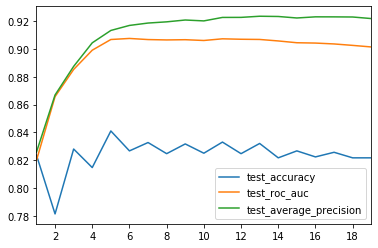

In [19]:
k_range = range(1, 20)
k_scores = pd.DataFrame(index=['test_accuracy','test_roc_auc','test_average_precision'] )

for k in k_range:
    knn = KNN(n_neighbors = k)
    scores = cross_validate(knn, Xtr, ytr, cv=5, scoring=['accuracy','roc_auc','average_precision'])
    k_score = pd.DataFrame(scores).mean()
    k_scores = pd.merge(k_scores, pd.DataFrame(k_score), left_index=True, right_index=True)
k_scores=k_scores.T
k_scores.index = np.arange(1, len(k_scores) + 1)
print(k_scores)

plt.figure()
k_scores.plot()
k_scores.idxmax()

In [28]:


# def auc_pr(y_true, y_pred):
# #    precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])
#     return auc(recall,precision)

# auc_pr = make_scorer(auc_pr, greater_is_better=True)
# scorers = {'accuracy': accuracy_score,
#            'roc_auc': roc_auc_score
#            'auc_pr': auc_pr}


knn_cv_std = GridSearchCV(
    Pipeline([
            ('standardize', StandardScaler()),
            ('knn', KNN())
    ]),
    {'knn__n_neighbors': list(range(1, 20)), 'knn__leaf_size': list(range(1, 40,3))},
    cv=skf,
    scoring='accuracy'
)

knn_cv_std.fit(Xtr, ytr)
knn_cv_std.predict(Xtt)

print("Best: %f using %s" % (knn_cv_std.best_score_,knn_cv_std.best_params_))




Best: 0.836333 using {'knn__leaf_size': 1, 'knn__n_neighbors': 5}


In [32]:
knn_cv_std.cv_results_

0.16598081588745117

# Q3
tune the hyperparameters of each classifier type (k for k-nearest neighbour, C and kernel type and parameters for SVM)

choose an optimal classifier between: k-nearest neighbour, Perceptron, Naïve Bayes Classifier, Logistic regression, Linear SVM and Kernelized SVM. 

Report the cross validation results (mean and standard deviation of accuracy, AUC-ROC and AUC-PR across fold) of your best model. You may look into grid search as well as ways of pre-processing data. Show code to demonstrate the results. Also show the comparison of these classifiers using a single table.

In [36]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
knn = KNN()
pct = Perceptron()
lr = LogisticRegression()
gnb = GaussianNB()
ksvm = SVC()
models = [knn, pct,lr, gnb, ksvm]

knn_para = {'knn__n_neighbors': list(range(1, 10)), 'knn__leaf_size': list(range(1, 40,10))}

parameters = [knn_para, pct_para,lr_para, gnb_para, ksvm_para]



NameError: name 'pct_para' is not defined

{'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'knn__leaf_size': [1, 11, 21, 31]}

In [37]:
scorers = ['accuracy','roc_auc','average_precision']

model_cv_pp = GridSearchCV(
    Pipeline([('standardize', StandardScaler()),
              ('normalize', Normalizer()),
              ('knn', knn)
    ]),
    parameters,
    cv=skf,
    scoring=scorers,
    refit = 'roc_auc',
    n_jobs = -1
)

model_cv_pp.fit(Xtr, ytr)
model_cv_pp.predict(Xtt)

print("Best: %f using %s" % (knn_cv_std.best_score_,knn_cv_std.best_params_))

KeyboardInterrupt: 

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
rf_params = {
    'C': [1,10, 100],
    "kernel":['linear','poly','rbf']
}
clf = SVC(gamma='scale')
grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
grid.fit(Xtr, ytr)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))

{'C': 100, 'kernel': 'rbf'}
Accuracy:0.842


In [ ]:
clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid={'logisticregression__C': [0.1, 10.]},
                                 cv=2,
                                 refit=True))

clf.fit()
clf.predict()

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)


X_train, X_test, y_train, y_test = train_test_split(
    Xtr, ytr, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1, 1e-2, 1e-3],
                     'C': [0.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}]

scores = ['accuracy','roc_auc','average_precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring= score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 0.1, 'kernel': 'linear'}

Grid scores on development set:

0.605 (+/-0.001) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.605 (+/-0.001) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.605 (+/-0.001) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.605 (+/-0.001) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.612 (+/-0.004) for {'C': 100, 'gam

/Users/liuminglan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'C': 0.1, 'kernel': 'linear'}

Grid scores on development set:

0.510 (+/-0.006) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.510 (+/-0.006) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.510 (+/-0.006) 

/Users/liuminglan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:

{'C': 0.1, 'kernel': 'linear'}

Grid scores on development set:

0.610 (+/-0.004) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.610 (+/-0.004) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.610 (+/-0.004) 

# Q4

In [ ]:
from sklearn.decomposition import PCA